# Image and photometry QA

The GALEX data are quite varied, complex, and somewhat messy (compared to other survey data sets). The various analyses and heuristics and flags are useful as _guides_ or _warning posts_ for analyses, but there is no substitute for actually looking at the data, especially the images, with _human eyes_ in order to assess their quality and suitabiility for your science.

Categories and consequences of various data quality issues and artfacts are discussed elsewhere in this documentation. This noteoobk provides some examples of common types of QA figures and analyses that you may want to use.

In [1]:
from rich import print
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pdr
from astropy.visualization import ZScaleInterval
from matplotlib.patches import Circle


In [18]:
# load a sample photometry and image
phot = pd.read_csv(f'test_data/e23456/e23456-nd-f0060-b00-movie-photom-12_8.csv')
image = pdr.read(f'test_data/e23456/e23456-nd-ffull-b00-image-r.fits')

In [23]:
image['COUNT'].shape

(3099, 3065)

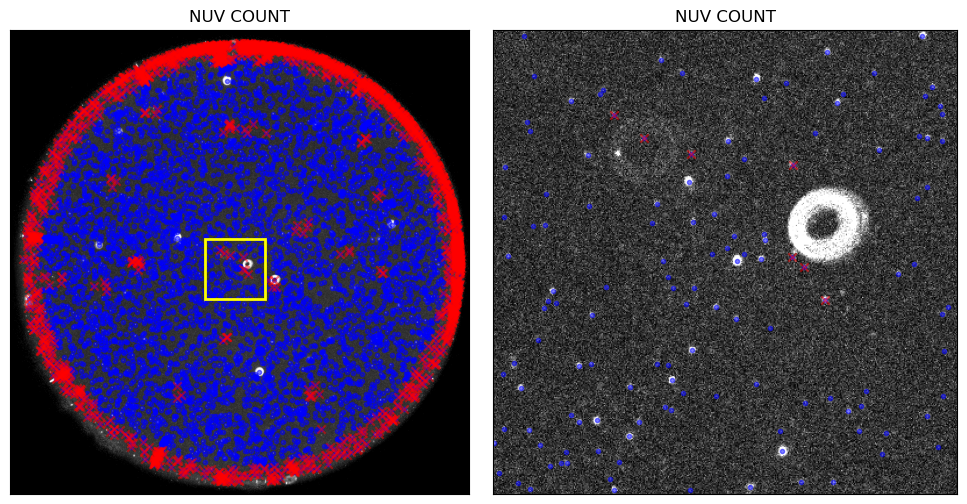

In [ ]:
k = 'COUNT'
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax_ix in range(len(axes)):
    axes[ax_ix].imshow(ZScaleInterval()(image[k]), cmap="binary_r", origin="lower")
    axes[ax_ix].set_title(f'NUV {k}')
    axes[ax_ix].set_xticks([])
    axes[ax_ix].set_yticks([])

    # axes[1].imshow(ZScaleInterval()(image_nd[k]), cmap="binary_r", origin="lower")
    # axes[1].set_title(f'NUV {k}')
    # axes[1].set_xticks([])
    # axes[1].set_yticks([])

    # plot all the source positions
    axes[ax_ix].scatter(phot[['xcenter','ycenter']].values.T[0], 
                    phot[['xcenter','ycenter']].values.T[1],
                    color='blue', marker='.', alpha=0.5)#, s=6)

    # plot all the source positions where flags are set
    axes[ax_ix].scatter(phot[phot['artifact_flag'] > 0][['xcenter','ycenter']].values.T[0], 
                    phot[phot['artifact_flag'] > 0][['xcenter','ycenter']].values.T[1],
                    color='red', marker='.', alpha=0.5)#, s=6, label='flagged')
    
    if ax_ix == 0:
        axes[ax_ix].add_patch(
            plt.Rectangle((1300,1300), 400, 400, linewidth=2, edgecolor='yellow', facecolor='none')
        )
    if ax_ix == 1:
        # crop the subframe to a random part of the image
        axes[ax_ix].set_xlim(1300, 1700)
        axes[ax_ix].set_ylim(1300, 1700)

plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

In [5]:
# Generate derived photometry (from the "basic photometry" notebook)
nframes = len([True for k in phot.keys() if 'expt_' in k])
aperture_sums = np.array([phot[f'aperture_sum_{N}'].values for N in range(nframes)]).T
expts = np.array([phot[f'expt_{N}'].values for N in range(nframes)]).T
t0s = np.array([phot[f't0_{N}'].values for N in range(nframes)]).T
t1s = np.array([phot[f't1_{N}'].values for N in range(nframes)]).T # equivalent to t0s + expts

# Bit mask: set artifact_flags to 1 if bit 0 is set, 8 if bit 3 is set, else 0
artifact_flags = np.zeros_like(aperture_sums, dtype=int)
for N in range(nframes):
    flags = phot[f'artifact_flag_{N}'].values
    artifact_flags[:, N] = np.where(flags & 1, 1, np.where(flags & 4, 4, 0))

# Now divide the aperture sums by the exposure times to get the counts per second
cps = aperture_sums / expts
cps_err = np.sqrt(aperture_sums) / expts

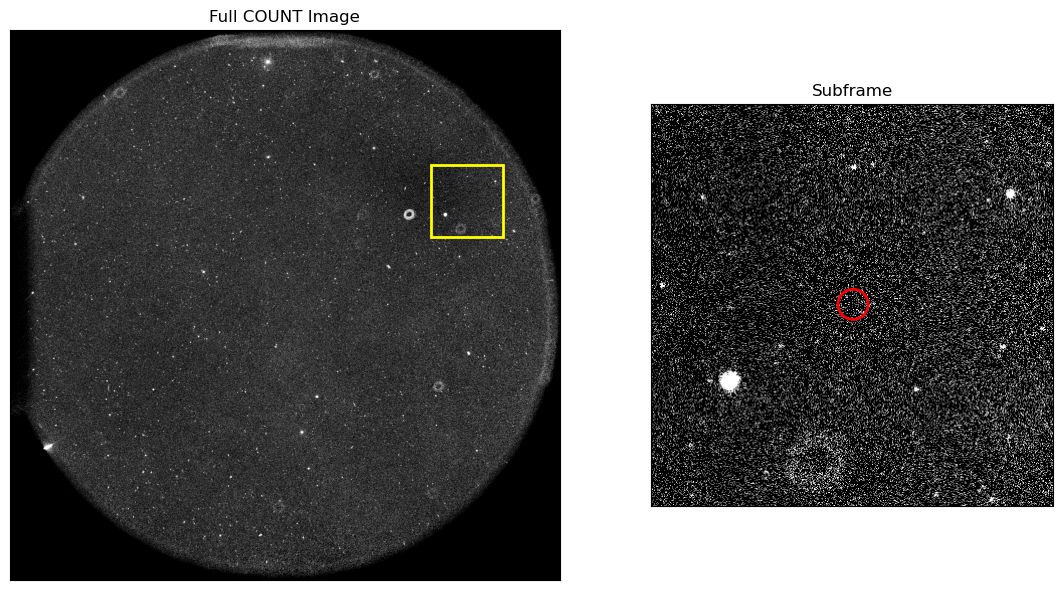

In [6]:
from matplotlib.patches import Circle

i = 4800 # a semi-random source as an example
imgx,imgy = phot[['xcenter', 'ycenter']].values[i]
imsz = np.shape(image['COUNT'])

# crop the subframe
# noting that image coordinates and numpy coordinates are flipped
boxsz = 200 # half width of subframe image
x1, x2, y1, y2 = (max(int(imgy - boxsz),0),
                    min(int(imgy + boxsz),imsz[0]),
                    max(int(imgx - boxsz),0),
                    min(int(imgx + boxsz),imsz[1]))

gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])
fig = plt.figure(figsize=(12, 6))

# Left panel: full COUNT image
ax_full = fig.add_subplot(gs[0, 0])
ax_full.imshow(ZScaleInterval()(image['COUNT']), origin='lower', cmap='gray')
rect = plt.Rectangle((y1, x1), y2 - y1, x2 - x1, linewidth=2, edgecolor='yellow', facecolor='none')
ax_full.add_patch(rect)
ax_full.set_title('Full COUNT Image')
ax_full.set_xticks([])
ax_full.set_yticks([])

# Right panel: subframe
ax_sub = fig.add_subplot(gs[0, 1])
ax_sub.imshow(ZScaleInterval()(image['COUNT'][x1:x2, y1:y2]), origin='lower', cmap='gray')
ax_sub.set_title('Subframe')
ax_sub.set_xticks([])
ax_sub.set_yticks([])

# Indicate the location of the source with a circle
circ = Circle((imgy - x1, imgx - y1), radius=15, edgecolor='red', facecolor='none', linewidth=2)
ax_sub.add_patch(circ)

plt.tight_layout()
plt.show()

In [7]:
def generate_qa_plots(vartable:dict,band='NUV',
                      photdir='/Users/cm/GFCAT/photom',
                      plotdir='/Users/cm/GFCAT/plots',
                      cleanup=False,
                      boxsz = 200, # pixels margin, so 2x this is the width
                      rerun = False,
                      depth = 30,
                        ):
    for e in tqdm.tqdm(vartable.keys()):
        if not rerun and all([os.path.exists(f'{plotdir}/e{str(e).zfill(5)}-{band}-{str(i).zfill(4)}.png') for i in vartable[e]]):
            continue # these QA plots have already been created, so skip
        edir = f'e{str(e).zfill(5)}'
        photpath = f'{photdir}/{edir}/{edir}-{band.lower()[0]}d-30s-photom.csv'
        lightcurves = parse_lightcurves(photpath)
        expt = parse_exposure_time(photpath.replace('photom.csv', 'exptime.csv'))
        cntfilename = f'{photdir}/e{str(e).zfill(5)}/e{str(e).zfill(5)}-{band[0].lower()}d-full.fits.gz'
        movfilename = cntfilename.replace('full',str(depth).zfille(2))
        if not os.path.exists(movfilename):
            aws_path = movfilename.replace(f"{photdir}","s3://dream-pool")
            cmd = f'aws s3 cp {aws_path} {fn} --quiet'
            os.system(cmd)
            if not os.path.exists(movfilename):
                raise FileNotFoundError(f'This eclipse has lightcurves so this image files should definitely exist:\n{movfilename}')

        movmap,flagmap,edgemap,wcs,tranges,exptimes=read_image(movfilename)
        movmap[np.where(np.isinf(movmap))]=0 # because it pops out with inf values... IDK
        movmap[np.where(movmap<0)]=0

        for source_ix in vartable[e]:
            lc = lightcurves[source_ix]
            assert len(lc['cps'])==np.shape(movmap)[0] # if these don't match then the gif will be out of sync
            imgx, imgy = lc['xcenter'],lc['ycenter'] # the image pixel coordinate of the source
            # define the bounding box for the thumbnail
            imsz = np.shape(movmap[0])

            # crop on the subframe
            # noting that image coordinates and numpy coordinates are flipped
            boxsz = 200
            x1, x2, y1, y2 = (max(int(imgy - boxsz),0),
                              min(int(imgy + boxsz),imsz[0]),
                              max(int(imgx - boxsz),0),
                              min(int(imgx + boxsz),imsz[1]))

            # crop on the full frame
            # The cropping is here to handle very wide images created by inappropriate handling
            # of map cos(theta) projection distortions when initializing the image size during processing;
            # this was fixed in the pipeline that generated the final run of gfcat data.
            x1_,x2_,y1_,y2_ = (max(int(imsz[0]/2-imsz[0]/2),0),
                               min(int(imsz[0]/2+imsz[0]/2),imsz[0]),
                               max(int(imsz[1]/2-imsz[0]/2),0),
                               min(int(imsz[1]/2+imsz[0]/2),imsz[1]))

            gs = gridspec.GridSpec(nrows=4, ncols=6)#, height_ratios=[1, 1, 2])

            for i,frame in enumerate(movmap): # probably eliminate the first / last frame, which always has lower exposure
                fig = plt.figure(figsize=(12,9));
                fig.tight_layout()
                ax = fig.add_subplot(gs[:3,:3])
                opacity = (edgemap[i]+flagmap[i])/2
                # M, N, 3 or M, N, 4
                ax.imshow(edgemap[i][x1_:x2_,y1_:y2_],origin="lower",cmap="Reds",alpha=opacity[x1_:x2_,y1_:y2_])
                ax.imshow(flagmap[i][x1_:x2_,y1_:y2_],origin="lower",cmap="Blues",alpha=opacity[x1_:x2_,y1_:y2_])
                ax.imshow(np.stack([ZScaleInterval()(frame[x1_:x2_,y1_:y2_]),
                                     ZScaleInterval()(frame[x1_:x2_,y1_:y2_]),
                                     ZScaleInterval()(frame[x1_:x2_,y1_:y2_]),
                                     1-opacity[x1_:x2_,y1_:y2_]],axis=2),origin="lower")
                ax.set_xticks([])
                ax.set_yticks([])
                rect = Rectangle((y1-y1_, x1-x1_), 2*boxsz, 2*boxsz, linewidth=1, edgecolor='y', facecolor='none',ls='solid')
                ax.add_patch(rect)

                ax = fig.add_subplot(gs[:3,3:])
                ax.imshow(edgemap[i][x1:x2,y1:y2],origin="lower",cmap="Reds",alpha=opacity[x1:x2,y1:y2])
                ax.imshow(flagmap[i][x1:x2,y1:y2],origin="lower",cmap="Blues",alpha=opacity[x1:x2,y1:y2])
                ax.imshow(np.stack([ZScaleInterval()(frame[x1:x2,y1:y2]),
                                     ZScaleInterval()(frame[x1:x2,y1:y2]),
                                     ZScaleInterval()(frame[x1:x2,y1:y2]),
                                     1-opacity[x1:x2,y1:y2]],axis=2),origin="lower")
                ax.set_xticks([])
                ax.set_xticks([])
                ax.set_yticks([])
                circ = Circle((boxsz,boxsz),20,linewidth=1,edgecolor='y',facecolor='none',ls='solid')
                ax.add_patch(circ)

                ax = fig.add_subplot(gs[3:,:])
                ax.set_xticks([])
                t = np.arange(len(lc['cps']))
                cps = lc['cps']
                cps_err = lc['cps_err']
                min_i,max_i=np.argmin(cps),np.argmax(cps)
                ax.vlines(t[i],cps[min_i]-3*cps_err[min_i],
                               cps[max_i]+3*cps_err[max_i],ls='dotted')
                ax.scatter(t[i],cps[i],c='y',s=100,marker='o')
                ax.errorbar(t,cps,yerr=cps_err*3,fmt='k.-')

                plt.savefig(f'{plotdir}/e{e}/e{e}-{b}-30s-{str(i).zfill(2)}-{str(source_ix).zfill(5)}.png',dpi=100)
                plt.close('all')

            n_frames = np.shape(movmap)[0]
            # write the animated gif
            gif_fn = f'{plotdir}/e{e}/e{e}-{b}-30s-{str(source_ix).zfill(5)}.gif'
            print(f"writing {gif_fn}")
            with imageio.get_writer(gif_fn, mode='I', fps=6) as writer:
                for i in np.arange(n_frames):
                    frame_fn = f'{plotdir}/e{e}/e{e}-{b}-30s-{str(i).zfill(2)}-{str(source_ix).zfill(5)}.png'
                    image = imageio.imread(frame_fn)
                    writer.append_data(image)
                    if cleanup: # remove the png frames
                        os.remove(frame_fn)

        if cleanup: # remove the local fits data
            os.system(f'rm -rf {photdir}/e{str(e).zfill(5)}/*fits*')
    return
